In [4]:
import pickle, gzip
import numpy as np
from scipy.ndimage import rotate
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models

In [6]:
# Load data
X, y = pickle.load(gzip.open("flatland_train.data", 'rb'))
X_eval, Y_eval = pickle.load(gzip.open("flatland_test.data", 'rb'))

* Possible y values are [0,3,4,5,6]. Replace them directly with [0,1,2,3,4]
* Normalize X values
* Use padding

In [7]:
# Adjust labels
y_new = np.where(y == 0, 0, y - 2)
# Normalize data
X = X / 255.0
X_eval = X_eval / 255.0
# Apply Sobel edge detection with padding
def apply_sobel_with_padding(X, padding=1):
    from scipy.ndimage import sobel
    X_sobel = np.zeros((X.shape[0], X.shape[1] + 2 * padding, X.shape[2] + 2 * padding))
    for i in range(X.shape[0]):
        padded_image = np.pad(X[i], padding, mode='edge')
        sobel_x = sobel(padded_image, axis=0)
        sobel_y = sobel(padded_image, axis=1)
        magnitude = np.sqrt(sobel_x**2 + sobel_y**2)
        X_sobel[i] = magnitude
    return X_sobel

X_sobel = apply_sobel_with_padding(X)
X_eval_sobel = apply_sobel_with_padding(X_eval)

* Add extra shapes with known y values to improve testing

In [8]:
# Augment dataset
papildyta_aibe = []
for image in X_sobel:
    papildyta_aibe.append(image)  # Append the original image
    # Add rotated images
    papildyta_aibe.append(rotate(image, 45, reshape=False))
    papildyta_aibe.append(rotate(image, 135, reshape=False))
    papildyta_aibe.append(rotate(image, 225, reshape=False))
    papildyta_aibe.append(rotate(image, 315, reshape=False))

papildyta_aibe = np.stack(papildyta_aibe)
y_augmented = np.repeat(y_new, 5)  # Repeat labels for augmented dataset

* Show visual results of reshaping

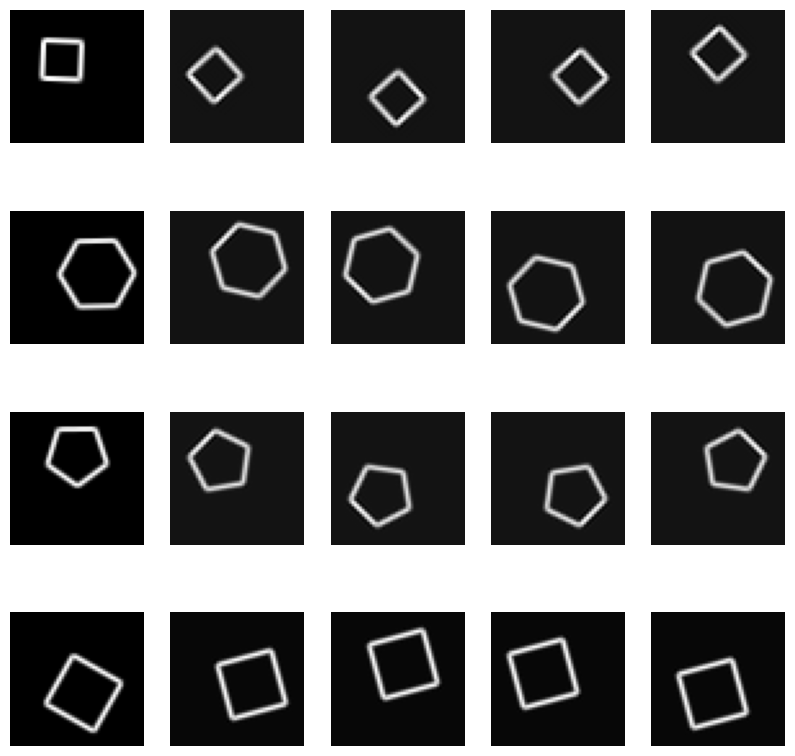

In [13]:
# prompt: show images with 20 rotations, use plt.figure plt.show()

import matplotlib.pyplot as plt
import numpy as np
fig = plt.figure(figsize=(10, 10))
for i in range(20):
    ax = fig.add_subplot(4, 5, i + 1)  # Create a subplot
    ax.imshow(papildyta_aibe[i], cmap='gray')  # Display the image
    ax.axis('off')  # Turn off axis labels

# Show the figure
plt.show()

 * Creating CNN model


In [9]:
# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(papildyta_aibe, y_augmented, test_size=0.2, random_state=42)

# Create CNN model
def create_cnn_model(input_shape):
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(5, activation='softmax'))  # Assuming 5 classes

    return model

* Training the model

In [10]:
# Compile and train the model
input_shape = (52, 52, 1)  # Height, width, channels
model = create_cnn_model(input_shape)
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Reshape data for training
X_train = X_train.reshape(-1, 52, 52, 1)  # Add channel dimension
X_val = X_val.reshape(-1, 52, 52, 1)

# Train the model
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.7246 - loss: 0.7304 - val_accuracy: 0.9843 - val_loss: 0.1339
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9818 - loss: 0.1340 - val_accuracy: 0.9830 - val_loss: 0.1242
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9829 - loss: 0.1172 - val_accuracy: 0.9842 - val_loss: 0.1214
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9831 - loss: 0.1023 - val_accuracy: 0.9850 - val_loss: 0.1128
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.9829 - loss: 0.0901 - val_accuracy: 0.9854 - val_loss: 0.1139
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.9845 - loss: 0.0774 - val_accuracy: 0.9823 - val_loss: 0.1224
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9824 - loss: 0.0743 - val_accuracy: 0.9855 - val_loss: 0.1226
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9848 - loss: 0.0621 -

* Print all predictions from model

In [15]:
# Evaluate the model
val_loss, val_accuracy = model.evaluate(X_val, y_val)
print(f'Validation accuracy: {val_accuracy:.4f}')

X_eval_sobel = apply_sobel_with_padding(X_eval)  # Apply Sobel to test data
X_eval_sobel = X_eval_sobel.reshape(-1, 52, 52, 1)  # Reshape for the model

# Make predictions
predictions = model.predict(X_eval_sobel)

# Convert predictions to class labels (0 to 4)
predicted_classes = np.argmax(predictions, axis=1)

# Mapping from new class labels back to original labels
label_mapping = {0: 0, 1: 3, 2: 4, 3: 5, 4: 6}

# Convert predicted classes back to original labels
original_predictions = [label_mapping[cls] for cls in predicted_classes]

# Convert the predictions to a single string of numbers
predicted_string = ''.join(map(str, original_predictions))

# Print the result
print(predicted_string)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9819 - loss: 0.1626
Validation accuracy: 0.9818
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
6645533343400053340545465644540453050355000363004353364306664054553303655503043350530604500355355463530403305345345040035360650004055530445455543654345046545635035636546303536656365650360605600463530335353336335465353306053565453360450054500063446060346543400453633455440546354503340300344553655053543306444055353443406030605300054655506334530544330054354500443044350645463346050306504305553645045355533336636330650644345564344535003644433063304055544504505345553050664300303444544504030306344006554333400506536544630334035643434343650403330363503435603556453440550543403430450565505303434536554355435035004453066464556036403330463455364406563043554443345350503053556660564533436350334356344353343060333043443433504546433334035630054450544503643600503355633556300553303033036463444400546453433660505604345456530403330035505464006564430553033355340544530633